In [1]:
import torch
import os
import matplotlib.pyplot as plt
from models.dense_baseline import get_baseline
from models.moe_model import MoEModel
from train import train_baseline, train_moe
from utils.data_loader import get_dataloaders
from utils.visualization import (
    HistoryLogger, 
    plot_multimodel_learning_curves, 
    plot_expert_utilization,
    plot_expert_utilization_histogram,
    plot_expert_counts_evolution,
    plot_expert_loss_history, 
    plot_expert_heatmap_from_history,
    compare_params_vs_performance,
    count_total_params,
    count_active_params_moe
)

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data
batch_size = 128
train_loader, val_loader, test_loader, num_classes, img_size = get_dataloaders(batch_size=batch_size)

# Global Settings
DEFAULT_EPOCHS = 10
SAVE_DIR = './experiment_results'
os.makedirs(SAVE_DIR, exist_ok=True)

/home/arthur/miniconda3/envs/ML/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda
Loaded CIFAR-10: 45000 train, 5000 val, 10000 test images.


# 1. Train Models

## 1.1 Dense Baselines
We train three baselines to control for parameter count and FLOPs.
*   **Baseline (x1.0):** Matches the *active* parameters of a 4-expert MoE (Approx).
*   **Baseline (x2.0):** Intermediate size.
*   **Baseline (x3.0):** Matches the *total* parameters of a 4-expert MoE (Approx).

In [2]:
baseline_models = {}
baseline_histories = {}

# Define configs
baseline_configs = [
    {'width': 1.0, 'epochs': DEFAULT_EPOCHS},
    {'width': 2.0, 'epochs': DEFAULT_EPOCHS},
    {'width': 3.0, 'epochs': DEFAULT_EPOCHS}
]

for cfg in baseline_configs:
    w = cfg['width']
    epochs = cfg.get('epochs', DEFAULT_EPOCHS)
    
    print(f"\n=== Training Baseline (Width x{w}, Epochs={epochs}) ===")
    model = get_baseline(input_shape=img_size, num_classes=num_classes, width_multiplier=w).to(device)
    
    save_path = os.path.join(SAVE_DIR, f'baseline_w{w}.pth')
    
    # Train
    train_baseline(model, train_loader, val_loader, test_loader, epochs, device, save_path)
    
    # Store for analysis
    baseline_models[f'Baseline_x{w}'] = model
    baseline_histories[f'Baseline_x{w}'] = HistoryLogger.load(save_path.replace('.pth', '_history.json'))


=== Training Baseline (Width x1.0, Epochs=10) ===
Starting Baseline training on cuda...


Epoch 1/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 73.40it/s, loss=1.67, acc=38.8]


Epoch 1: Train Acc: 38.85%, Val Acc: 50.46%, Val Loss: 1.4009, Test Acc: 53.31%


Epoch 2/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 75.89it/s, loss=1.22, acc=56.2]


Epoch 2: Train Acc: 56.15%, Val Acc: 57.78%, Val Loss: 1.1908, Test Acc: 61.68%


Epoch 3/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 77.03it/s, loss=1.05, acc=63.1]


Epoch 3: Train Acc: 63.12%, Val Acc: 61.26%, Val Loss: 1.1442, Test Acc: 66.21%


Epoch 4/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 75.93it/s, loss=0.931, acc=67.6]


Epoch 4: Train Acc: 67.63%, Val Acc: 65.10%, Val Loss: 1.0458, Test Acc: 66.59%


Epoch 5/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 74.34it/s, loss=0.839, acc=70.7]


Epoch 5: Train Acc: 70.65%, Val Acc: 66.02%, Val Loss: 0.9669, Test Acc: 68.98%


Epoch 6/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 75.46it/s, loss=0.756, acc=73.6]


Epoch 6: Train Acc: 73.56%, Val Acc: 70.46%, Val Loss: 0.8628, Test Acc: 70.46%


Epoch 7/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 77.37it/s, loss=0.681, acc=76.4]


Epoch 7: Train Acc: 76.43%, Val Acc: 73.04%, Val Loss: 0.7855, Test Acc: 75.25%


Epoch 8/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 75.40it/s, loss=0.617, acc=78.5]


Epoch 8: Train Acc: 78.46%, Val Acc: 77.10%, Val Loss: 0.6511, Test Acc: 78.40%


Epoch 9/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 75.57it/s, loss=0.562, acc=80.6]


Epoch 9: Train Acc: 80.55%, Val Acc: 78.74%, Val Loss: 0.6088, Test Acc: 80.09%


Epoch 10/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 75.93it/s, loss=0.527, acc=81.7]


Epoch 10: Train Acc: 81.66%, Val Acc: 79.60%, Val Loss: 0.5925, Test Acc: 81.12%
Training finished. Final Test Accuracy: 81.12%

=== Training Baseline (Width x2.0, Epochs=10) ===
Starting Baseline training on cuda...


Epoch 1/10 [Train]: 100%|██████████| 352/352 [00:05<00:00, 62.40it/s, loss=1.91, acc=29.7]


Epoch 1: Train Acc: 29.70%, Val Acc: 44.08%, Val Loss: 1.4910, Test Acc: 46.00%


Epoch 2/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 74.70it/s, loss=1.36, acc=50.9]


Epoch 2: Train Acc: 50.94%, Val Acc: 57.12%, Val Loss: 1.2203, Test Acc: 58.92%


Epoch 3/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.27it/s, loss=1.1, acc=61]   


Epoch 3: Train Acc: 60.99%, Val Acc: 63.88%, Val Loss: 1.0412, Test Acc: 65.64%


Epoch 4/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.27it/s, loss=0.929, acc=67.3]


Epoch 4: Train Acc: 67.25%, Val Acc: 65.50%, Val Loss: 0.9987, Test Acc: 67.91%


Epoch 5/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 75.57it/s, loss=0.837, acc=71]  


Epoch 5: Train Acc: 71.00%, Val Acc: 70.36%, Val Loss: 0.8341, Test Acc: 73.12%


Epoch 6/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.89it/s, loss=0.738, acc=74.3]


Epoch 6: Train Acc: 74.28%, Val Acc: 73.04%, Val Loss: 0.7589, Test Acc: 74.83%


Epoch 7/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.48it/s, loss=0.645, acc=77.3]


Epoch 7: Train Acc: 77.28%, Val Acc: 76.22%, Val Loss: 0.6873, Test Acc: 77.13%


Epoch 8/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.24it/s, loss=0.578, acc=79.7]


Epoch 8: Train Acc: 79.74%, Val Acc: 78.68%, Val Loss: 0.6169, Test Acc: 79.99%


Epoch 9/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 76.44it/s, loss=0.511, acc=82.2]


Epoch 9: Train Acc: 82.18%, Val Acc: 80.80%, Val Loss: 0.5479, Test Acc: 81.82%


Epoch 10/10 [Train]: 100%|██████████| 352/352 [00:04<00:00, 73.71it/s, loss=0.466, acc=84]  


Epoch 10: Train Acc: 83.97%, Val Acc: 81.24%, Val Loss: 0.5315, Test Acc: 82.28%
Training finished. Final Test Accuracy: 82.28%

=== Training Baseline (Width x3.0, Epochs=10) ===
Starting Baseline training on cuda...


Epoch 1/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.97it/s, loss=2.11, acc=21.8]


Epoch 1: Train Acc: 21.81%, Val Acc: 26.16%, Val Loss: 1.8952, Test Acc: 26.21%


Epoch 2/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.23it/s, loss=1.59, acc=40.2]


Epoch 2: Train Acc: 40.23%, Val Acc: 48.96%, Val Loss: 1.3904, Test Acc: 52.21%


Epoch 3/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.42it/s, loss=1.21, acc=56.3]


Epoch 3: Train Acc: 56.29%, Val Acc: 58.54%, Val Loss: 1.1784, Test Acc: 58.91%


Epoch 4/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.52it/s, loss=0.989, acc=65.2]


Epoch 4: Train Acc: 65.18%, Val Acc: 65.24%, Val Loss: 0.9864, Test Acc: 68.31%


Epoch 5/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.38it/s, loss=0.859, acc=69.8]


Epoch 5: Train Acc: 69.83%, Val Acc: 69.52%, Val Loss: 0.8693, Test Acc: 72.64%


Epoch 6/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.51it/s, loss=0.743, acc=74.1]


Epoch 6: Train Acc: 74.14%, Val Acc: 74.54%, Val Loss: 0.7417, Test Acc: 75.90%


Epoch 7/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.47it/s, loss=0.656, acc=77.3]


Epoch 7: Train Acc: 77.32%, Val Acc: 76.94%, Val Loss: 0.6544, Test Acc: 78.33%


Epoch 8/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.17it/s, loss=0.566, acc=80.4]


Epoch 8: Train Acc: 80.44%, Val Acc: 79.14%, Val Loss: 0.6130, Test Acc: 79.73%


Epoch 9/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 54.05it/s, loss=0.503, acc=82.7]


Epoch 9: Train Acc: 82.66%, Val Acc: 80.10%, Val Loss: 0.5672, Test Acc: 81.00%


Epoch 10/10 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.97it/s, loss=0.454, acc=84.4]


Epoch 10: Train Acc: 84.43%, Val Acc: 81.90%, Val Loss: 0.5168, Test Acc: 82.52%
Training finished. Final Test Accuracy: 82.52%


## 1.2 MoE Models
We vary `top_k`, `num_experts`, and `aux_weight` (load balancing regularization).

*   **MoE 4 Exp, Top-1, Aux 0.0:** Control (No balancing).
*   **MoE 4 Exp, Top-1, Aux 3.0:** Standard balanced.
*   **MoE 4 Exp, Top-2, Aux 3.0:** Routing to multiple experts.
*   **MoE 4 Exp, Top-2, Aux 6.0:** High regularization.
*   **MoE 8 Exp, Top-2, Aux 8.0:** Scaling up experts.

In [3]:
moe_configs = [
    {'name': 'MoE_4E_Top1_Aux0.0', 'experts': 4, 'topk': 1, 'aux': 0.0, 'epochs': DEFAULT_EPOCHS},
    {'name': 'MoE_4E_Top1_Aux3.0', 'experts': 4, 'topk': 1, 'aux': 3.0, 'epochs': DEFAULT_EPOCHS*2},
    {'name': 'MoE_4E_Top2_Aux3.0', 'experts': 4, 'topk': 2, 'aux': 3.0, 'epochs': DEFAULT_EPOCHS*2},
    {'name': 'MoE_4E_Top2_Aux6.0', 'experts': 4, 'topk': 2, 'aux': 6.0, 'epochs': DEFAULT_EPOCHS*2},
    {'name': 'MoE_8E_Top2_Aux10.0', 'experts': 8, 'topk': 2, 'aux': 10.0, 'epochs': DEFAULT_EPOCHS*3},
]

moe_models = {}
moe_histories = {}

for cfg in moe_configs:
    epochs = cfg.get('epochs', DEFAULT_EPOCHS)
    print(f"\n=== Training {cfg['name']} (Epochs={epochs}) ===")
    model = MoEModel(num_experts=cfg['experts'], num_classes=num_classes, 
                     input_channels=img_size[0], top_k=cfg['topk']).to(device)
    
    save_path = os.path.join(SAVE_DIR, f"{cfg['name']}.pth")
    
    train_moe(model, train_loader, val_loader, test_loader, epochs, device, save_path, aux_weight=cfg['aux'])
    
    moe_models[cfg['name']] = model
    moe_histories[cfg['name']] = HistoryLogger.load(save_path.replace('.pth', '_history.json'))


=== Training MoE_4E_Top1_Aux0.0 (Epochs=10) ===
Starting MoE training on cuda with aux_weight=0.0, Top-K=1


Epoch 1/10: 100%|██████████| 352/352 [00:04<00:00, 70.82it/s, loss=1.67, acc=39.2]


Epoch 1: Train: 39.24% | Val: 51.58% | Test: 53.37%
   Usage: [E0:0.4% | E1:4.1% | E2:95.0% | E3:0.5%]


Epoch 2/10: 100%|██████████| 352/352 [00:04<00:00, 74.29it/s, loss=1.21, acc=56.7]


Epoch 2: Train: 56.68% | Val: 61.56% | Test: 63.79%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 3/10: 100%|██████████| 352/352 [00:04<00:00, 76.17it/s, loss=1.04, acc=63.3]


Epoch 3: Train: 63.26% | Val: 64.62% | Test: 67.59%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 4/10: 100%|██████████| 352/352 [00:04<00:00, 76.45it/s, loss=0.926, acc=67.4]


Epoch 4: Train: 67.40% | Val: 68.44% | Test: 71.04%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 5/10: 100%|██████████| 352/352 [00:04<00:00, 74.24it/s, loss=0.836, acc=70.7]


Epoch 5: Train: 70.72% | Val: 68.80% | Test: 70.57%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 6/10: 100%|██████████| 352/352 [00:05<00:00, 70.04it/s, loss=0.765, acc=73.3]


Epoch 6: Train: 73.35% | Val: 71.02% | Test: 72.50%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 7/10: 100%|██████████| 352/352 [00:04<00:00, 72.86it/s, loss=0.692, acc=76]  


Epoch 7: Train: 75.97% | Val: 75.52% | Test: 76.56%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 8/10: 100%|██████████| 352/352 [00:04<00:00, 72.04it/s, loss=0.626, acc=78.2]


Epoch 8: Train: 78.17% | Val: 77.00% | Test: 78.93%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 9/10: 100%|██████████| 352/352 [00:04<00:00, 72.97it/s, loss=0.566, acc=80.2]


Epoch 9: Train: 80.16% | Val: 78.96% | Test: 79.79%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]


Epoch 10/10: 100%|██████████| 352/352 [00:04<00:00, 72.64it/s, loss=0.531, acc=81.6]


Epoch 10: Train: 81.60% | Val: 79.30% | Test: 80.81%
   Usage: [E0:0.0% | E1:0.0% | E2:100.0% | E3:0.0%]
MoE Training finished. Final Test Accuracy: 80.81%

=== Training MoE_4E_Top1_Aux3.0 (Epochs=20) ===
Starting MoE training on cuda with aux_weight=3.0, Top-K=1


Epoch 1/20: 100%|██████████| 352/352 [00:04<00:00, 71.02it/s, loss=1.95, acc=34]  


Epoch 1: Train: 34.02% | Val: 37.06% | Test: 40.14%
   Usage: [E0:4.9% | E1:43.2% | E2:43.0% | E3:8.9%]


Epoch 2/20: 100%|██████████| 352/352 [00:04<00:00, 71.22it/s, loss=1.62, acc=42]  


Epoch 2: Train: 41.98% | Val: 42.58% | Test: 46.57%
   Usage: [E0:21.5% | E1:28.1% | E2:26.9% | E3:23.5%]


Epoch 3/20: 100%|██████████| 352/352 [00:05<00:00, 70.30it/s, loss=1.43, acc=49.3]


Epoch 3: Train: 49.29% | Val: 51.58% | Test: 56.48%
   Usage: [E0:23.2% | E1:28.6% | E2:26.6% | E3:21.6%]


Epoch 4/20: 100%|██████████| 352/352 [00:05<00:00, 68.94it/s, loss=1.3, acc=54]   


Epoch 4: Train: 54.04% | Val: 54.02% | Test: 57.06%
   Usage: [E0:22.3% | E1:29.4% | E2:25.3% | E3:23.0%]


Epoch 5/20: 100%|██████████| 352/352 [00:05<00:00, 68.54it/s, loss=1.2, acc=57.9] 


Epoch 5: Train: 57.87% | Val: 56.54% | Test: 58.47%
   Usage: [E0:23.0% | E1:27.7% | E2:24.5% | E3:24.7%]


Epoch 6/20: 100%|██████████| 352/352 [00:05<00:00, 69.18it/s, loss=1.14, acc=60.1]


Epoch 6: Train: 60.06% | Val: 59.08% | Test: 63.64%
   Usage: [E0:25.6% | E1:25.1% | E2:24.8% | E3:24.5%]


Epoch 7/20: 100%|██████████| 352/352 [00:04<00:00, 71.09it/s, loss=1.08, acc=62.2]


Epoch 7: Train: 62.21% | Val: 57.14% | Test: 61.16%
   Usage: [E0:23.1% | E1:26.2% | E2:25.2% | E3:25.5%]


Epoch 8/20: 100%|██████████| 352/352 [00:05<00:00, 69.83it/s, loss=1.04, acc=64.1]


Epoch 8: Train: 64.13% | Val: 60.94% | Test: 64.55%
   Usage: [E0:24.5% | E1:26.1% | E2:25.8% | E3:23.6%]


Epoch 9/20: 100%|██████████| 352/352 [00:05<00:00, 69.96it/s, loss=0.977, acc=65.8]


Epoch 9: Train: 65.80% | Val: 63.82% | Test: 65.47%
   Usage: [E0:26.0% | E1:24.8% | E2:23.4% | E3:25.8%]


Epoch 10/20: 100%|██████████| 352/352 [00:05<00:00, 69.70it/s, loss=0.939, acc=67.4]


Epoch 10: Train: 67.38% | Val: 62.48% | Test: 65.05%
   Usage: [E0:26.2% | E1:24.3% | E2:27.4% | E3:22.1%]


Epoch 11/20: 100%|██████████| 352/352 [00:04<00:00, 70.50it/s, loss=0.886, acc=69.5]


Epoch 11: Train: 69.48% | Val: 67.88% | Test: 70.95%
   Usage: [E0:25.4% | E1:25.4% | E2:22.7% | E3:26.5%]


Epoch 12/20: 100%|██████████| 352/352 [00:04<00:00, 70.99it/s, loss=0.838, acc=71]  


Epoch 12: Train: 70.97% | Val: 69.12% | Test: 72.24%
   Usage: [E0:23.1% | E1:28.0% | E2:24.1% | E3:24.9%]


Epoch 13/20: 100%|██████████| 352/352 [00:05<00:00, 69.58it/s, loss=0.783, acc=72.8]


Epoch 13: Train: 72.82% | Val: 70.44% | Test: 73.08%
   Usage: [E0:24.9% | E1:26.6% | E2:24.8% | E3:23.6%]


Epoch 14/20: 100%|██████████| 352/352 [00:05<00:00, 70.32it/s, loss=0.744, acc=74.4]


Epoch 14: Train: 74.36% | Val: 70.26% | Test: 72.89%
   Usage: [E0:24.3% | E1:26.5% | E2:24.2% | E3:25.0%]


Epoch 15/20: 100%|██████████| 352/352 [00:05<00:00, 69.48it/s, loss=0.702, acc=75.7]


Epoch 15: Train: 75.69% | Val: 73.32% | Test: 74.28%
   Usage: [E0:25.5% | E1:25.7% | E2:24.7% | E3:24.1%]


Epoch 16/20: 100%|██████████| 352/352 [00:05<00:00, 69.84it/s, loss=0.656, acc=77.5]


Epoch 16: Train: 77.49% | Val: 75.48% | Test: 78.06%
   Usage: [E0:24.0% | E1:26.0% | E2:25.6% | E3:24.5%]


Epoch 17/20: 100%|██████████| 352/352 [00:05<00:00, 69.70it/s, loss=0.617, acc=78.6]


Epoch 17: Train: 78.63% | Val: 75.78% | Test: 77.92%
   Usage: [E0:25.7% | E1:25.9% | E2:23.6% | E3:24.9%]


Epoch 18/20: 100%|██████████| 352/352 [00:05<00:00, 69.35it/s, loss=0.584, acc=80.1]


Epoch 18: Train: 80.12% | Val: 76.58% | Test: 78.35%
   Usage: [E0:24.7% | E1:24.9% | E2:24.8% | E3:25.7%]


Epoch 19/20: 100%|██████████| 352/352 [00:05<00:00, 70.13it/s, loss=0.559, acc=80.9]


Epoch 19: Train: 80.89% | Val: 78.32% | Test: 79.42%
   Usage: [E0:25.4% | E1:25.5% | E2:25.1% | E3:23.9%]


Epoch 20/20: 100%|██████████| 352/352 [00:05<00:00, 70.24it/s, loss=0.544, acc=81.6]


Epoch 20: Train: 81.57% | Val: 77.98% | Test: 79.77%
   Usage: [E0:25.3% | E1:25.2% | E2:25.2% | E3:24.4%]
MoE Training finished. Final Test Accuracy: 79.77%

=== Training MoE_4E_Top2_Aux3.0 (Epochs=20) ===
Starting MoE training on cuda with aux_weight=3.0, Top-K=2


Epoch 1/20: 100%|██████████| 352/352 [00:05<00:00, 69.51it/s, loss=1.85, acc=34.2]


Epoch 1: Train: 34.22% | Val: 41.94% | Test: 43.80%
   Usage: [E0:40.1% | E1:29.8% | E2:23.3% | E3:6.7%]


Epoch 2/20: 100%|██████████| 352/352 [00:05<00:00, 68.46it/s, loss=1.49, acc=46.4]


Epoch 2: Train: 46.36% | Val: 54.16% | Test: 55.06%
   Usage: [E0:32.4% | E1:22.3% | E2:20.0% | E3:25.3%]


Epoch 3/20: 100%|██████████| 352/352 [00:05<00:00, 69.08it/s, loss=1.3, acc=54.4] 


Epoch 3: Train: 54.38% | Val: 56.64% | Test: 58.21%
   Usage: [E0:32.0% | E1:23.8% | E2:19.2% | E3:25.0%]


Epoch 4/20: 100%|██████████| 352/352 [00:04<00:00, 70.71it/s, loss=1.17, acc=59]  


Epoch 4: Train: 58.99% | Val: 59.82% | Test: 61.81%
   Usage: [E0:30.4% | E1:23.6% | E2:21.3% | E3:24.7%]


Epoch 5/20: 100%|██████████| 352/352 [00:05<00:00, 69.39it/s, loss=1.08, acc=62.1]


Epoch 5: Train: 62.14% | Val: 59.78% | Test: 63.14%
   Usage: [E0:31.2% | E1:23.0% | E2:21.0% | E3:24.8%]


Epoch 6/20: 100%|██████████| 352/352 [00:05<00:00, 69.68it/s, loss=1.02, acc=64.7]


Epoch 6: Train: 64.65% | Val: 63.20% | Test: 66.25%
   Usage: [E0:30.4% | E1:23.5% | E2:20.6% | E3:25.4%]


Epoch 7/20: 100%|██████████| 352/352 [00:05<00:00, 70.27it/s, loss=0.969, acc=66.7]


Epoch 7: Train: 66.66% | Val: 64.66% | Test: 68.19%
   Usage: [E0:29.5% | E1:23.3% | E2:21.4% | E3:25.8%]


Epoch 8/20: 100%|██████████| 352/352 [00:05<00:00, 66.87it/s, loss=0.923, acc=68.1]


Epoch 8: Train: 68.12% | Val: 66.56% | Test: 69.17%
   Usage: [E0:29.3% | E1:23.1% | E2:20.7% | E3:26.9%]


Epoch 9/20: 100%|██████████| 352/352 [00:05<00:00, 67.32it/s, loss=0.878, acc=69.7]


Epoch 9: Train: 69.75% | Val: 67.92% | Test: 70.57%
   Usage: [E0:29.3% | E1:22.9% | E2:21.1% | E3:26.7%]


Epoch 10/20: 100%|██████████| 352/352 [00:05<00:00, 68.01it/s, loss=0.842, acc=70.9]


Epoch 10: Train: 70.94% | Val: 68.86% | Test: 71.38%
   Usage: [E0:29.1% | E1:23.0% | E2:20.4% | E3:27.6%]


Epoch 11/20: 100%|██████████| 352/352 [00:05<00:00, 68.75it/s, loss=0.801, acc=72.4]


Epoch 11: Train: 72.41% | Val: 69.16% | Test: 72.29%
   Usage: [E0:29.1% | E1:22.9% | E2:20.2% | E3:27.7%]


Epoch 12/20: 100%|██████████| 352/352 [00:05<00:00, 68.48it/s, loss=0.762, acc=73.7]


Epoch 12: Train: 73.74% | Val: 72.00% | Test: 74.47%
   Usage: [E0:28.8% | E1:22.6% | E2:20.2% | E3:28.4%]


Epoch 13/20: 100%|██████████| 352/352 [00:05<00:00, 68.33it/s, loss=0.727, acc=75]  


Epoch 13: Train: 75.02% | Val: 72.90% | Test: 74.47%
   Usage: [E0:28.8% | E1:22.8% | E2:19.9% | E3:28.6%]


Epoch 14/20: 100%|██████████| 352/352 [00:05<00:00, 69.44it/s, loss=0.681, acc=76.6]


Epoch 14: Train: 76.65% | Val: 73.82% | Test: 76.55%
   Usage: [E0:29.0% | E1:22.3% | E2:20.4% | E3:28.3%]


Epoch 15/20: 100%|██████████| 352/352 [00:05<00:00, 68.55it/s, loss=0.644, acc=78]  


Epoch 15: Train: 77.98% | Val: 75.04% | Test: 77.37%
   Usage: [E0:29.0% | E1:21.9% | E2:19.7% | E3:29.4%]


Epoch 16/20: 100%|██████████| 352/352 [00:05<00:00, 68.44it/s, loss=0.601, acc=79.6]


Epoch 16: Train: 79.62% | Val: 76.86% | Test: 79.01%
   Usage: [E0:28.3% | E1:22.2% | E2:19.9% | E3:29.5%]


Epoch 17/20: 100%|██████████| 352/352 [00:05<00:00, 69.28it/s, loss=0.562, acc=80.9]


Epoch 17: Train: 80.86% | Val: 77.96% | Test: 79.99%
   Usage: [E0:28.5% | E1:22.2% | E2:19.8% | E3:29.4%]


Epoch 18/20: 100%|██████████| 352/352 [00:05<00:00, 69.03it/s, loss=0.537, acc=81.7]


Epoch 18: Train: 81.72% | Val: 78.82% | Test: 80.43%
   Usage: [E0:28.6% | E1:21.8% | E2:19.9% | E3:29.7%]


Epoch 19/20: 100%|██████████| 352/352 [00:05<00:00, 68.84it/s, loss=0.513, acc=82.8]


Epoch 19: Train: 82.78% | Val: 79.54% | Test: 81.25%
   Usage: [E0:28.2% | E1:22.1% | E2:19.5% | E3:30.2%]


Epoch 20/20: 100%|██████████| 352/352 [00:05<00:00, 66.50it/s, loss=0.499, acc=83.2]


Epoch 20: Train: 83.15% | Val: 80.46% | Test: 81.37%
   Usage: [E0:28.2% | E1:22.1% | E2:19.6% | E3:30.1%]
MoE Training finished. Final Test Accuracy: 81.37%

=== Training MoE_4E_Top2_Aux6.0 (Epochs=20) ===
Starting MoE training on cuda with aux_weight=6.0, Top-K=2


Epoch 1/20: 100%|██████████| 352/352 [00:05<00:00, 69.78it/s, loss=2.08, acc=38.6]


Epoch 1: Train: 38.62% | Val: 47.92% | Test: 49.94%
   Usage: [E0:49.7% | E1:0.3% | E2:0.3% | E3:49.7%]


Epoch 2/20: 100%|██████████| 352/352 [00:05<00:00, 69.64it/s, loss=1.62, acc=47.1]


Epoch 2: Train: 47.13% | Val: 43.60% | Test: 46.67%
   Usage: [E0:42.2% | E1:13.5% | E2:13.2% | E3:31.0%]


Epoch 3/20: 100%|██████████| 352/352 [00:05<00:00, 68.89it/s, loss=1.33, acc=52.7]


Epoch 3: Train: 52.71% | Val: 53.00% | Test: 55.81%
   Usage: [E0:28.9% | E1:27.1% | E2:25.1% | E3:18.9%]


Epoch 4/20: 100%|██████████| 352/352 [00:05<00:00, 68.57it/s, loss=1.2, acc=57.9] 


Epoch 4: Train: 57.87% | Val: 58.42% | Test: 62.34%
   Usage: [E0:25.4% | E1:27.7% | E2:28.8% | E3:18.2%]


Epoch 5/20: 100%|██████████| 352/352 [00:05<00:00, 69.44it/s, loss=1.13, acc=60.3]


Epoch 5: Train: 60.34% | Val: 61.14% | Test: 64.19%
   Usage: [E0:24.5% | E1:27.4% | E2:29.8% | E3:18.3%]


Epoch 6/20: 100%|██████████| 352/352 [00:05<00:00, 68.96it/s, loss=1.05, acc=63.3]


Epoch 6: Train: 63.27% | Val: 61.98% | Test: 64.52%
   Usage: [E0:23.3% | E1:27.7% | E2:30.8% | E3:18.2%]


Epoch 7/20: 100%|██████████| 352/352 [00:05<00:00, 65.99it/s, loss=0.988, acc=65.5]


Epoch 7: Train: 65.47% | Val: 64.62% | Test: 66.94%
   Usage: [E0:23.1% | E1:27.9% | E2:30.5% | E3:18.4%]


Epoch 8/20: 100%|██████████| 352/352 [00:05<00:00, 67.84it/s, loss=0.938, acc=67.4]


Epoch 8: Train: 67.44% | Val: 67.22% | Test: 69.34%
   Usage: [E0:22.4% | E1:28.3% | E2:30.9% | E3:18.4%]


Epoch 9/20: 100%|██████████| 352/352 [00:05<00:00, 68.87it/s, loss=0.893, acc=68.8]


Epoch 9: Train: 68.85% | Val: 66.94% | Test: 68.42%
   Usage: [E0:22.1% | E1:28.6% | E2:31.4% | E3:18.0%]


Epoch 10/20: 100%|██████████| 352/352 [00:05<00:00, 68.81it/s, loss=0.851, acc=70.5]


Epoch 10: Train: 70.50% | Val: 69.04% | Test: 70.57%
   Usage: [E0:21.6% | E1:29.1% | E2:31.4% | E3:17.9%]


Epoch 11/20: 100%|██████████| 352/352 [00:05<00:00, 67.27it/s, loss=0.803, acc=72.2]


Epoch 11: Train: 72.15% | Val: 69.96% | Test: 72.14%
   Usage: [E0:21.6% | E1:28.6% | E2:31.3% | E3:18.5%]


Epoch 12/20: 100%|██████████| 352/352 [00:05<00:00, 69.46it/s, loss=0.771, acc=73.3]


Epoch 12: Train: 73.25% | Val: 72.74% | Test: 75.55%
   Usage: [E0:21.4% | E1:28.9% | E2:31.4% | E3:18.2%]


Epoch 13/20: 100%|██████████| 352/352 [00:05<00:00, 68.05it/s, loss=0.732, acc=74.8]


Epoch 13: Train: 74.80% | Val: 72.92% | Test: 75.56%
   Usage: [E0:21.2% | E1:29.3% | E2:31.0% | E3:18.5%]


Epoch 14/20: 100%|██████████| 352/352 [00:05<00:00, 69.02it/s, loss=0.689, acc=76.6]


Epoch 14: Train: 76.58% | Val: 74.72% | Test: 76.87%
   Usage: [E0:21.0% | E1:29.0% | E2:31.4% | E3:18.7%]


Epoch 15/20: 100%|██████████| 352/352 [00:05<00:00, 67.54it/s, loss=0.65, acc=77.7] 


Epoch 15: Train: 77.69% | Val: 75.40% | Test: 77.15%
   Usage: [E0:20.8% | E1:29.6% | E2:30.9% | E3:18.8%]


Epoch 16/20: 100%|██████████| 352/352 [00:05<00:00, 69.20it/s, loss=0.606, acc=79.4]


Epoch 16: Train: 79.39% | Val: 77.56% | Test: 78.91%
   Usage: [E0:20.4% | E1:29.5% | E2:30.8% | E3:19.2%]


Epoch 17/20: 100%|██████████| 352/352 [00:05<00:00, 67.47it/s, loss=0.574, acc=80.1]


Epoch 17: Train: 80.06% | Val: 77.98% | Test: 80.32%
   Usage: [E0:20.9% | E1:29.6% | E2:30.2% | E3:19.3%]


Epoch 18/20: 100%|██████████| 352/352 [00:05<00:00, 68.11it/s, loss=0.543, acc=81.5]


Epoch 18: Train: 81.52% | Val: 79.32% | Test: 80.71%
   Usage: [E0:20.4% | E1:29.3% | E2:30.9% | E3:19.4%]


Epoch 19/20: 100%|██████████| 352/352 [00:05<00:00, 69.27it/s, loss=0.524, acc=82.2]


Epoch 19: Train: 82.20% | Val: 80.40% | Test: 81.30%
   Usage: [E0:20.6% | E1:29.4% | E2:30.5% | E3:19.6%]


Epoch 20/20: 100%|██████████| 352/352 [00:05<00:00, 69.16it/s, loss=0.509, acc=82.8]


Epoch 20: Train: 82.81% | Val: 80.42% | Test: 81.51%
   Usage: [E0:20.3% | E1:29.4% | E2:30.6% | E3:19.7%]
MoE Training finished. Final Test Accuracy: 81.51%

=== Training MoE_8E_Top2_Aux10.0 (Epochs=30) ===
Starting MoE training on cuda with aux_weight=10.0, Top-K=2


Epoch 1/30: 100%|██████████| 352/352 [00:07<00:00, 47.93it/s, loss=1.85, acc=33.4]


Epoch 1: Train: 33.38% | Val: 38.38% | Test: 43.31%
   Usage: [E0:14.6% | E1:14.2% | E2:7.8% | E3:12.4% | E4:13.9% | E5:13.2% | E6:13.3% | E7:10.6%]


Epoch 2/30: 100%|██████████| 352/352 [00:08<00:00, 43.96it/s, loss=1.57, acc=43.2]


Epoch 2: Train: 43.23% | Val: 45.94% | Test: 46.26%
   Usage: [E0:13.9% | E1:14.6% | E2:12.1% | E3:11.5% | E4:12.8% | E5:10.9% | E6:11.9% | E7:12.4%]


Epoch 3/30: 100%|██████████| 352/352 [00:07<00:00, 45.26it/s, loss=1.44, acc=48.9]


Epoch 3: Train: 48.90% | Val: 50.02% | Test: 52.74%
   Usage: [E0:14.4% | E1:15.2% | E2:11.2% | E3:12.0% | E4:11.7% | E5:10.6% | E6:13.3% | E7:11.6%]


Epoch 4/30: 100%|██████████| 352/352 [00:07<00:00, 44.51it/s, loss=1.34, acc=52.6]


Epoch 4: Train: 52.59% | Val: 55.54% | Test: 57.35%
   Usage: [E0:12.3% | E1:14.4% | E2:11.6% | E3:14.1% | E4:11.6% | E5:11.3% | E6:11.9% | E7:12.8%]


Epoch 5/30: 100%|██████████| 352/352 [00:07<00:00, 45.98it/s, loss=1.26, acc=56]  


Epoch 5: Train: 55.96% | Val: 55.46% | Test: 58.62%
   Usage: [E0:13.7% | E1:15.5% | E2:11.7% | E3:12.3% | E4:12.3% | E5:10.3% | E6:12.3% | E7:11.8%]


Epoch 6/30: 100%|██████████| 352/352 [00:07<00:00, 45.44it/s, loss=1.19, acc=58.4]


Epoch 6: Train: 58.44% | Val: 57.66% | Test: 61.14%
   Usage: [E0:14.8% | E1:14.8% | E2:12.7% | E3:11.0% | E4:10.4% | E5:10.3% | E6:13.1% | E7:13.1%]


Epoch 7/30: 100%|██████████| 352/352 [00:07<00:00, 44.17it/s, loss=1.14, acc=60.5]


Epoch 7: Train: 60.50% | Val: 60.88% | Test: 62.84%
   Usage: [E0:14.4% | E1:14.9% | E2:13.0% | E3:9.3% | E4:11.6% | E5:10.8% | E6:12.4% | E7:13.7%]


Epoch 8/30: 100%|██████████| 352/352 [00:07<00:00, 45.21it/s, loss=1.1, acc=61.9] 


Epoch 8: Train: 61.93% | Val: 63.66% | Test: 67.00%
   Usage: [E0:13.5% | E1:14.6% | E2:12.1% | E3:10.2% | E4:11.7% | E5:11.2% | E6:12.6% | E7:13.9%]


Epoch 9/30: 100%|██████████| 352/352 [00:07<00:00, 44.32it/s, loss=1.06, acc=63.4]


Epoch 9: Train: 63.41% | Val: 60.88% | Test: 64.23%
   Usage: [E0:14.2% | E1:14.0% | E2:12.6% | E3:10.4% | E4:11.8% | E5:12.1% | E6:11.6% | E7:13.3%]


Epoch 10/30: 100%|██████████| 352/352 [00:07<00:00, 44.31it/s, loss=1.02, acc=64.7]


Epoch 10: Train: 64.70% | Val: 61.74% | Test: 63.69%
   Usage: [E0:13.7% | E1:13.8% | E2:11.9% | E3:9.6% | E4:11.4% | E5:11.8% | E6:13.6% | E7:14.1%]


Epoch 11/30: 100%|██████████| 352/352 [00:07<00:00, 46.24it/s, loss=0.989, acc=65.8]


Epoch 11: Train: 65.80% | Val: 63.72% | Test: 66.01%
   Usage: [E0:12.9% | E1:14.2% | E2:11.9% | E3:9.4% | E4:13.0% | E5:11.2% | E6:13.2% | E7:14.2%]


Epoch 12/30: 100%|██████████| 352/352 [00:07<00:00, 44.58it/s, loss=0.967, acc=66.8]


Epoch 12: Train: 66.77% | Val: 64.42% | Test: 66.71%
   Usage: [E0:13.4% | E1:14.8% | E2:12.3% | E3:9.0% | E4:12.3% | E5:10.8% | E6:12.9% | E7:14.5%]


Epoch 13/30: 100%|██████████| 352/352 [00:07<00:00, 44.89it/s, loss=0.929, acc=68.2]


Epoch 13: Train: 68.21% | Val: 64.52% | Test: 65.79%
   Usage: [E0:12.8% | E1:14.7% | E2:12.3% | E3:10.0% | E4:11.8% | E5:11.1% | E6:13.1% | E7:14.1%]


Epoch 14/30: 100%|██████████| 352/352 [00:07<00:00, 44.31it/s, loss=0.904, acc=68.8]


Epoch 14: Train: 68.85% | Val: 66.30% | Test: 68.04%
   Usage: [E0:12.5% | E1:13.3% | E2:12.3% | E3:10.2% | E4:12.8% | E5:11.7% | E6:13.0% | E7:14.1%]


Epoch 15/30: 100%|██████████| 352/352 [00:08<00:00, 43.21it/s, loss=0.879, acc=69.8]


Epoch 15: Train: 69.82% | Val: 67.22% | Test: 69.70%
   Usage: [E0:12.8% | E1:13.3% | E2:12.4% | E3:9.7% | E4:13.2% | E5:11.1% | E6:12.3% | E7:15.2%]


Epoch 16/30: 100%|██████████| 352/352 [00:07<00:00, 44.12it/s, loss=0.84, acc=71.1] 


Epoch 16: Train: 71.08% | Val: 68.62% | Test: 71.91%
   Usage: [E0:12.7% | E1:14.2% | E2:12.7% | E3:9.0% | E4:13.4% | E5:10.7% | E6:12.0% | E7:15.2%]


Epoch 17/30: 100%|██████████| 352/352 [00:07<00:00, 46.11it/s, loss=0.82, acc=72]   


Epoch 17: Train: 72.00% | Val: 69.84% | Test: 71.72%
   Usage: [E0:12.6% | E1:13.6% | E2:12.4% | E3:9.1% | E4:12.6% | E5:11.7% | E6:12.7% | E7:15.2%]


Epoch 18/30: 100%|██████████| 352/352 [00:07<00:00, 44.60it/s, loss=0.782, acc=73.3]


Epoch 18: Train: 73.26% | Val: 71.12% | Test: 73.04%
   Usage: [E0:12.5% | E1:14.2% | E2:12.2% | E3:10.0% | E4:12.4% | E5:11.0% | E6:12.8% | E7:15.0%]


Epoch 19/30: 100%|██████████| 352/352 [00:07<00:00, 44.62it/s, loss=0.762, acc=73.9]


Epoch 19: Train: 73.95% | Val: 72.06% | Test: 74.26%
   Usage: [E0:12.7% | E1:14.4% | E2:12.3% | E3:9.3% | E4:12.9% | E5:10.4% | E6:12.8% | E7:15.1%]


Epoch 20/30: 100%|██████████| 352/352 [00:07<00:00, 45.94it/s, loss=0.727, acc=75.1]


Epoch 20: Train: 75.12% | Val: 73.88% | Test: 74.84%
   Usage: [E0:12.0% | E1:14.8% | E2:12.1% | E3:9.3% | E4:12.7% | E5:10.8% | E6:13.2% | E7:15.1%]


Epoch 21/30: 100%|██████████| 352/352 [00:07<00:00, 44.40it/s, loss=0.698, acc=76.5]


Epoch 21: Train: 76.47% | Val: 74.18% | Test: 75.43%
   Usage: [E0:12.4% | E1:15.0% | E2:11.9% | E3:9.5% | E4:12.9% | E5:10.7% | E6:12.7% | E7:15.0%]


Epoch 22/30: 100%|██████████| 352/352 [00:07<00:00, 45.62it/s, loss=0.667, acc=77.5]


Epoch 22: Train: 77.48% | Val: 74.82% | Test: 76.20%
   Usage: [E0:12.3% | E1:15.0% | E2:12.2% | E3:9.4% | E4:13.6% | E5:10.3% | E6:12.8% | E7:14.5%]


Epoch 23/30: 100%|██████████| 352/352 [00:07<00:00, 45.18it/s, loss=0.645, acc=78]  


Epoch 23: Train: 78.05% | Val: 75.80% | Test: 77.53%
   Usage: [E0:11.9% | E1:14.9% | E2:12.0% | E3:9.4% | E4:13.5% | E5:10.6% | E6:13.1% | E7:14.5%]


Epoch 24/30: 100%|██████████| 352/352 [00:07<00:00, 45.56it/s, loss=0.606, acc=79.5]


Epoch 24: Train: 79.54% | Val: 75.92% | Test: 77.42%
   Usage: [E0:12.0% | E1:15.1% | E2:11.9% | E3:9.7% | E4:13.1% | E5:10.5% | E6:12.8% | E7:15.0%]


Epoch 25/30: 100%|██████████| 352/352 [00:08<00:00, 43.89it/s, loss=0.581, acc=80.5]


Epoch 25: Train: 80.46% | Val: 77.86% | Test: 78.82%
   Usage: [E0:11.9% | E1:14.9% | E2:12.0% | E3:9.0% | E4:13.7% | E5:10.4% | E6:13.1% | E7:14.9%]


Epoch 26/30: 100%|██████████| 352/352 [00:07<00:00, 45.10it/s, loss=0.551, acc=81.5]


Epoch 26: Train: 81.52% | Val: 79.30% | Test: 79.58%
   Usage: [E0:12.0% | E1:14.8% | E2:12.1% | E3:9.2% | E4:13.6% | E5:10.6% | E6:12.9% | E7:14.9%]


Epoch 27/30: 100%|██████████| 352/352 [00:07<00:00, 44.11it/s, loss=0.533, acc=82.3]


Epoch 27: Train: 82.30% | Val: 79.14% | Test: 79.97%
   Usage: [E0:12.2% | E1:14.7% | E2:12.2% | E3:9.2% | E4:13.9% | E5:10.5% | E6:12.8% | E7:14.5%]


Epoch 28/30: 100%|██████████| 352/352 [00:07<00:00, 45.13it/s, loss=0.513, acc=82.8]


Epoch 28: Train: 82.80% | Val: 79.10% | Test: 80.35%
   Usage: [E0:12.3% | E1:14.8% | E2:12.1% | E3:9.0% | E4:13.7% | E5:10.5% | E6:12.7% | E7:14.9%]


Epoch 29/30: 100%|██████████| 352/352 [00:07<00:00, 44.84it/s, loss=0.502, acc=83.5]


Epoch 29: Train: 83.49% | Val: 79.50% | Test: 80.81%
   Usage: [E0:12.2% | E1:14.7% | E2:12.1% | E3:9.5% | E4:13.8% | E5:10.5% | E6:12.8% | E7:14.5%]


Epoch 30/30: 100%|██████████| 352/352 [00:07<00:00, 45.27it/s, loss=0.493, acc=83.7]


Epoch 30: Train: 83.75% | Val: 79.12% | Test: 80.78%
   Usage: [E0:12.1% | E1:14.9% | E2:12.1% | E3:9.3% | E4:13.6% | E5:10.4% | E6:12.9% | E7:14.7%]
MoE Training finished. Final Test Accuracy: 80.78%


# 2. Global Performance Analysis

## 2.1 Training Dynamics (Accuracy & Loss)

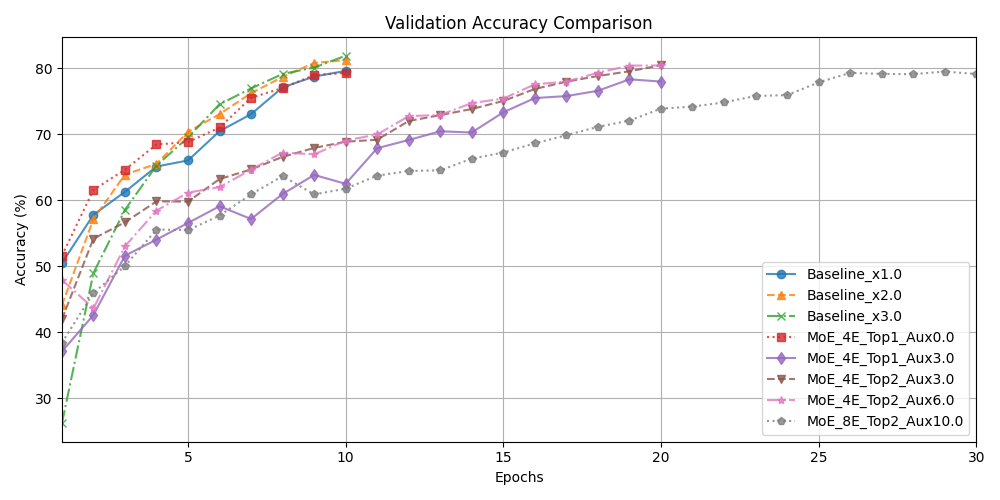

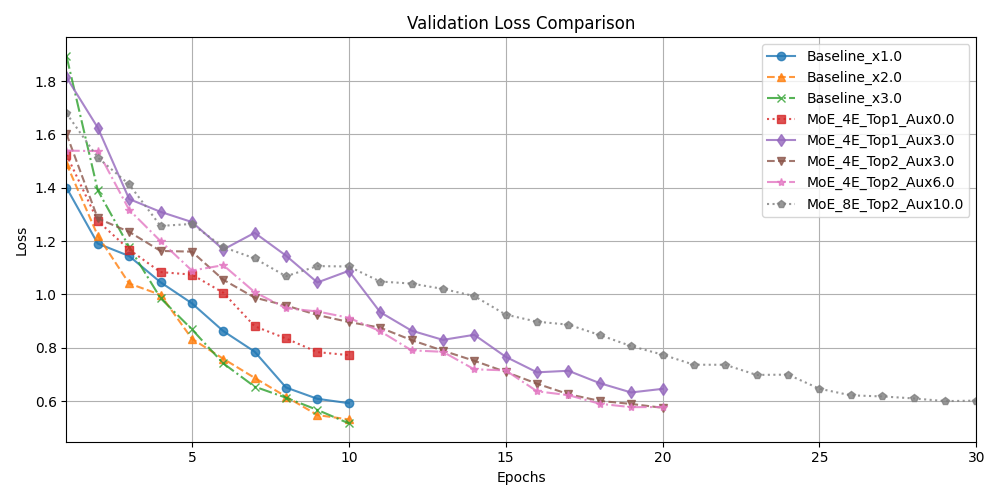

In [4]:
# Combine all histories for plotting
all_histories = {**baseline_histories, **moe_histories}

# Plot multimodel comparison
plot_multimodel_learning_curves(all_histories, SAVE_DIR)

# Display plots inline
from IPython.display import Image, display
display(Image(filename=os.path.join(SAVE_DIR, 'multimodel_comparison_accuracy.png')))
display(Image(filename=os.path.join(SAVE_DIR, 'multimodel_comparison_loss.png')))


## 2.2 Efficiency vs. Capacity
*   **Left:** Accuracy vs. Total Parameters (Storage Cost).
*   **Right:** Accuracy vs. Active Parameters (Inference Cost/Speed).

=== Accuracy vs Total Parameters (Storage) ===


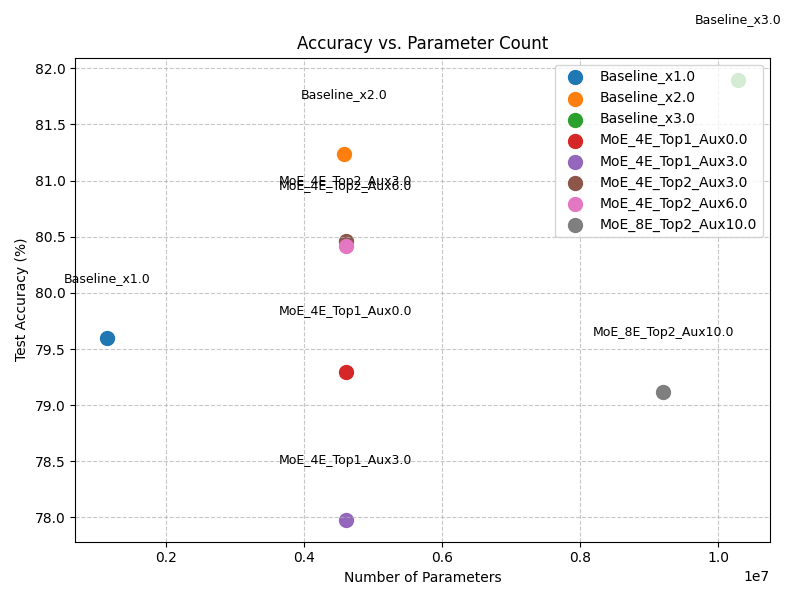


=== Accuracy vs Active Parameters (Inference FLOPs Proxy) ===


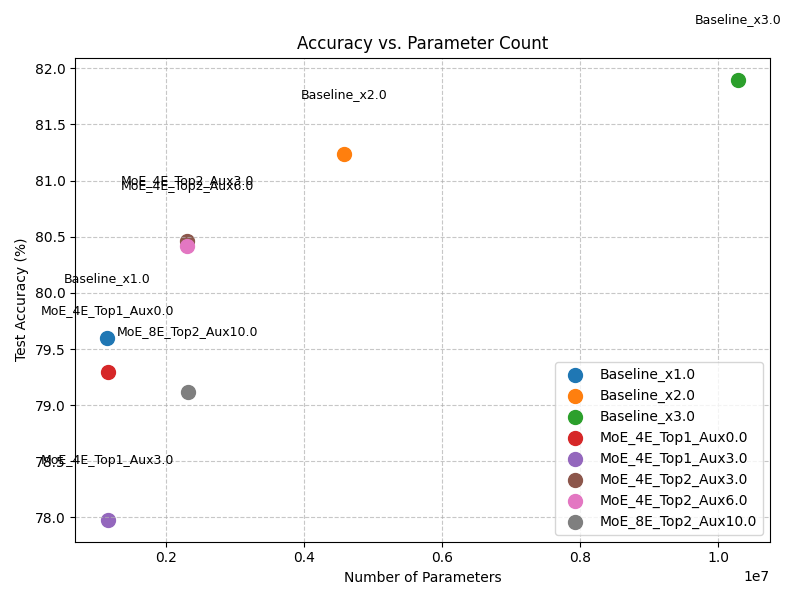

In [5]:
storage_data = [] # Accuracy vs Total Params
compute_data = [] # Accuracy vs Active Params

# Process Baselines
for name, model in baseline_models.items():
    acc = baseline_histories[name].history['val_acc'][-1]
    total_p = count_total_params(model)
    # For dense models, active = total
    storage_data.append({'name': name, 'params': total_p, 'accuracy': acc})
    compute_data.append({'name': name, 'params': total_p, 'accuracy': acc})

# Process MoEs
for name, model in moe_models.items():
    acc = moe_histories[name].history['val_acc'][-1]
    
    total_p = count_total_params(model)
    active_p = count_active_params_moe(model)
    
    storage_data.append({'name': name, 'params': total_p, 'accuracy': acc})
    compute_data.append({'name': name, 'params': active_p, 'accuracy': acc})

# Plot 1: Storage
print("=== Accuracy vs Total Parameters (Storage) ===")
compare_params_vs_performance(storage_data, os.path.join(SAVE_DIR, 'acc_vs_storage.png'))
display(Image(filename=os.path.join(SAVE_DIR, 'acc_vs_storage.png')))

# Plot 2: Compute
print("\n=== Accuracy vs Active Parameters (Inference FLOPs Proxy) ===")
compare_params_vs_performance(compute_data, os.path.join(SAVE_DIR, 'acc_vs_compute.png'))
display(Image(filename=os.path.join(SAVE_DIR, 'acc_vs_compute.png')))


# 3. Gating & Expert Analysis

We analyze how experts are utilized and how they learn.
*   **Utilization Histogram:** Did the experts handle an equal share of data?
*   **Counts Evolution:** How many samples per expert over time?
*   **Loss Evolution:** Did experts learn at the same speed?


--- Analyzing MoE_4E_Top1_Aux0.0 ---


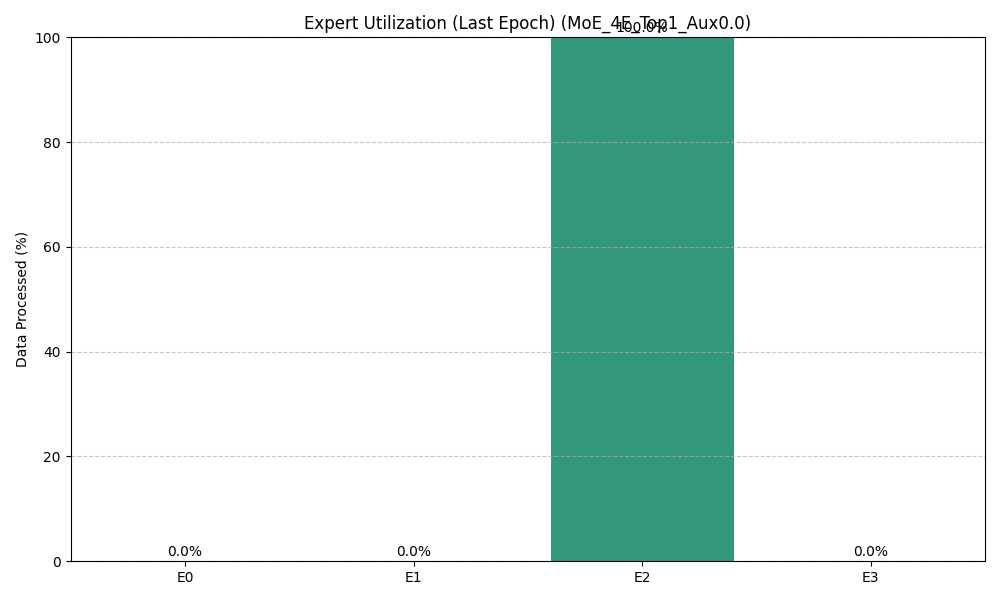

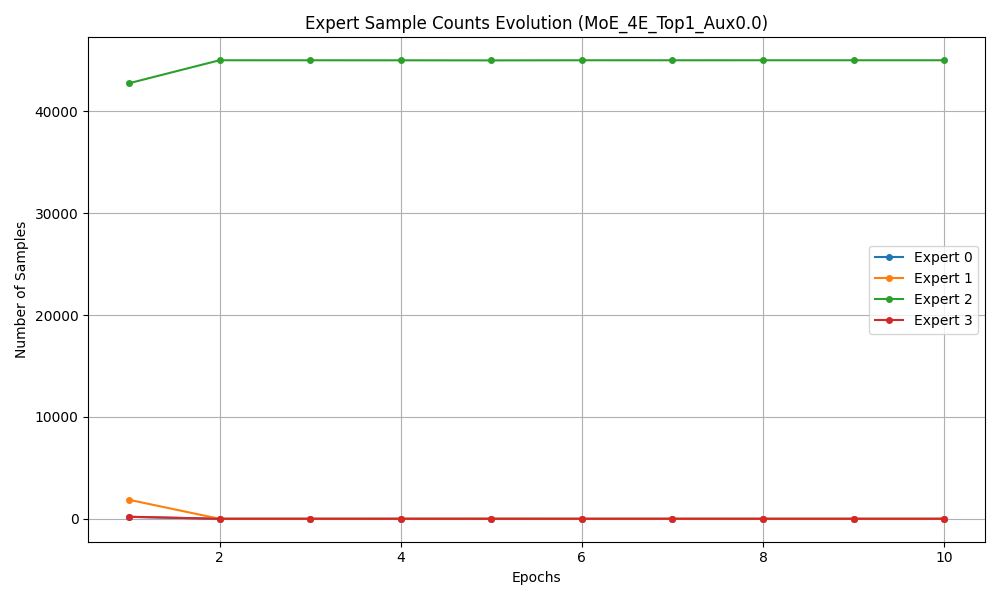

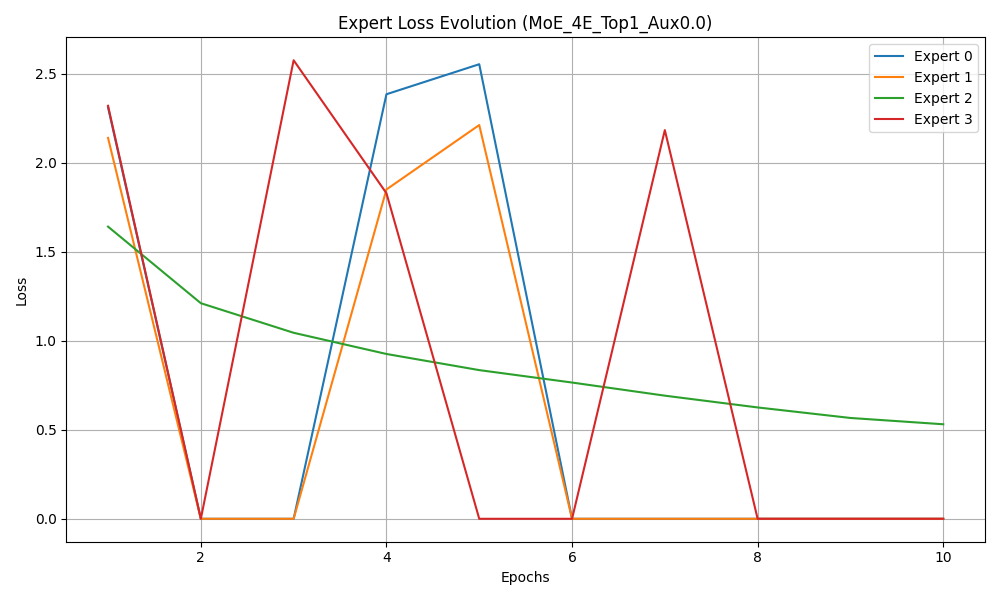


--- Analyzing MoE_4E_Top1_Aux3.0 ---


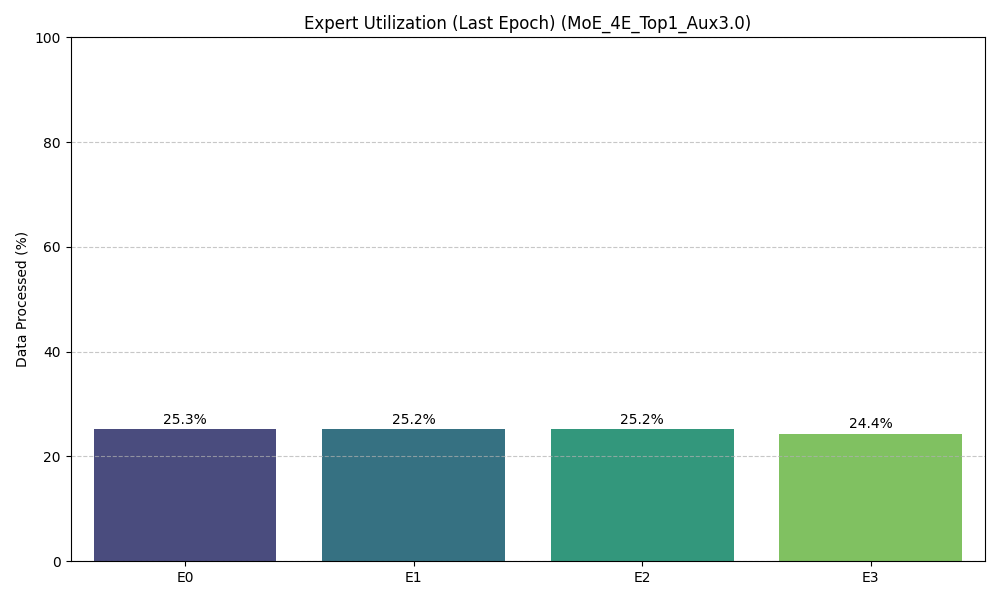

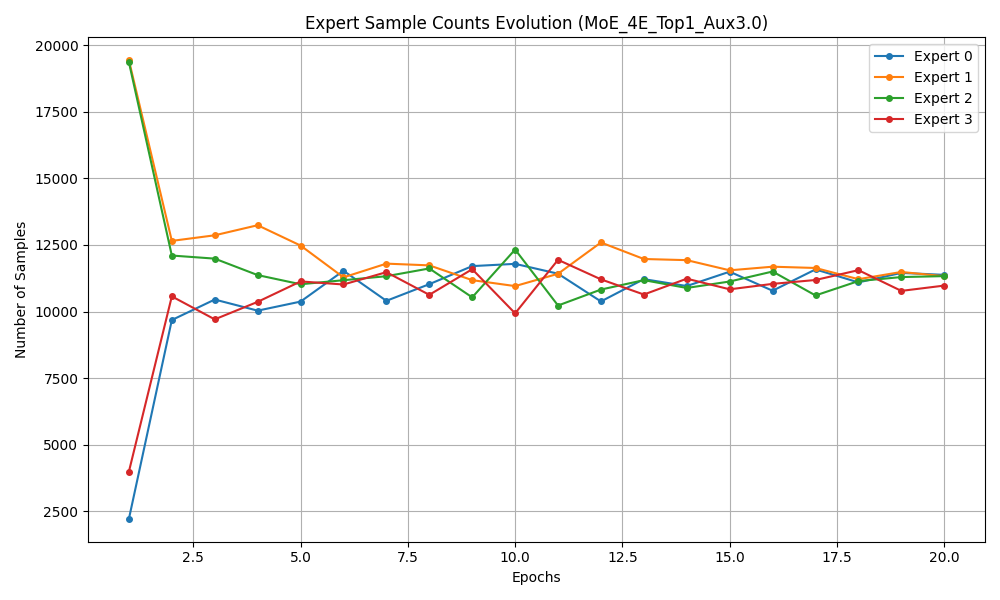

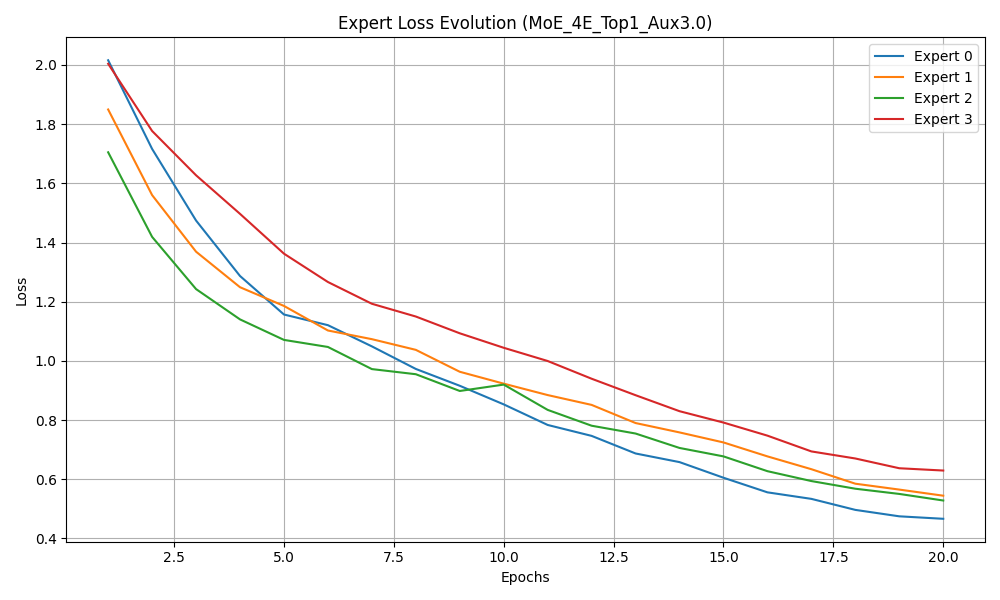


--- Analyzing MoE_4E_Top2_Aux3.0 ---


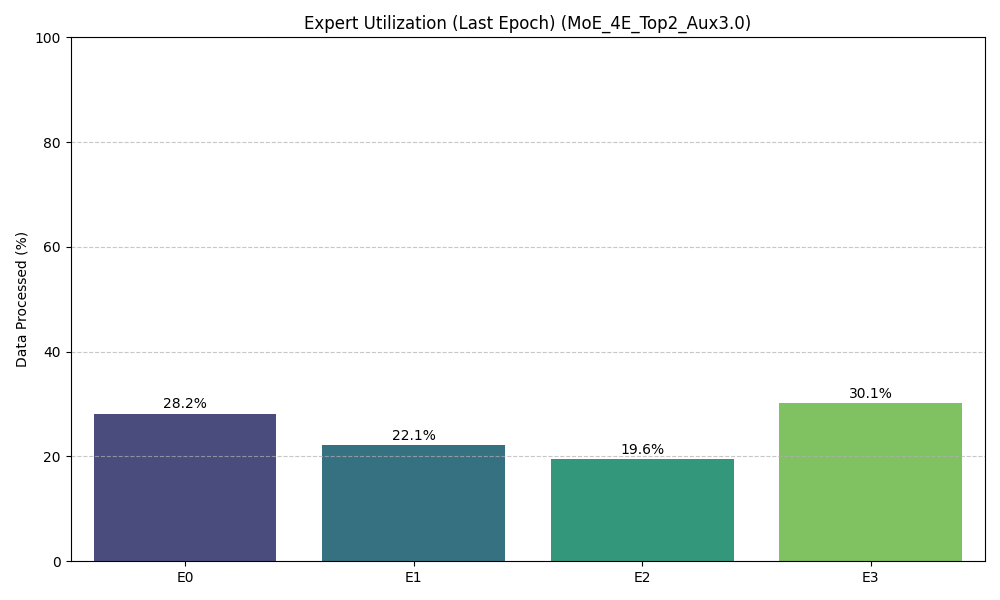

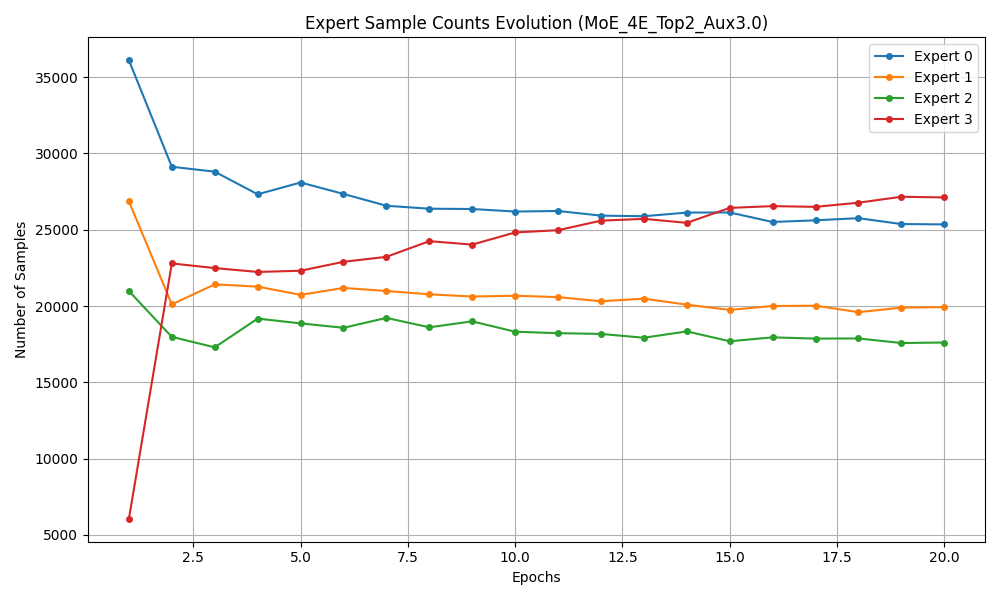

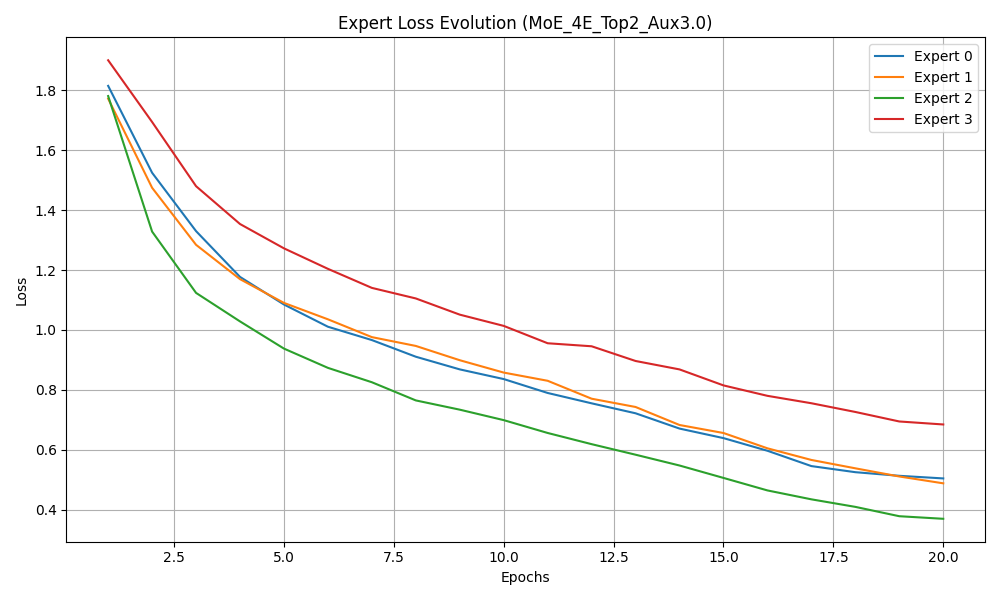


--- Analyzing MoE_4E_Top2_Aux6.0 ---


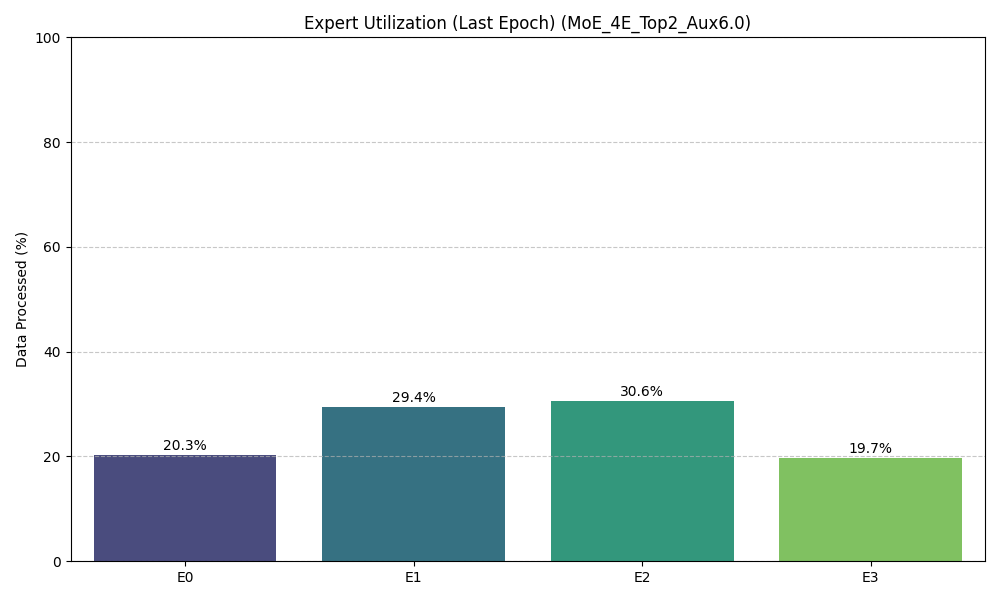

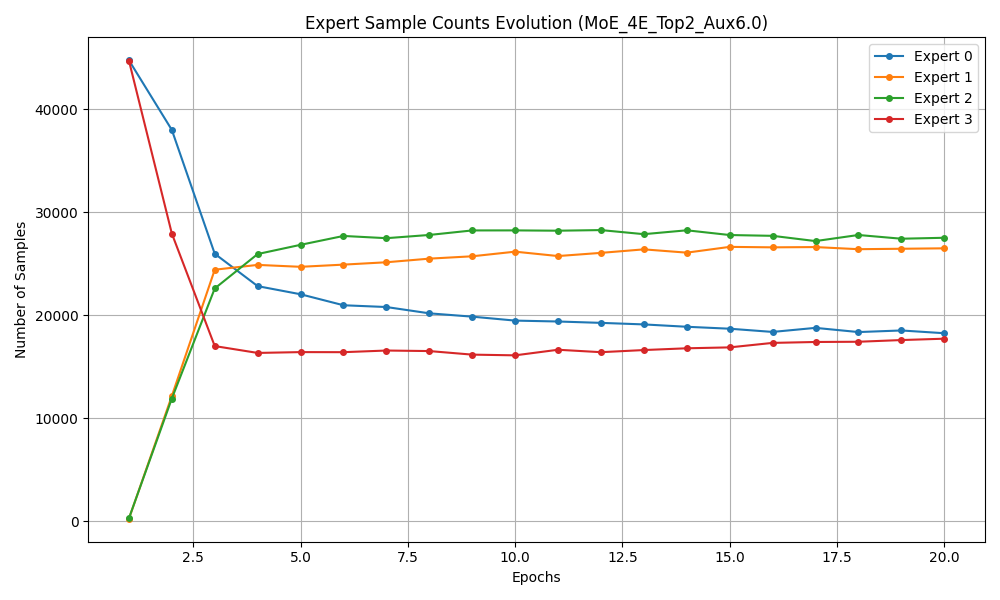

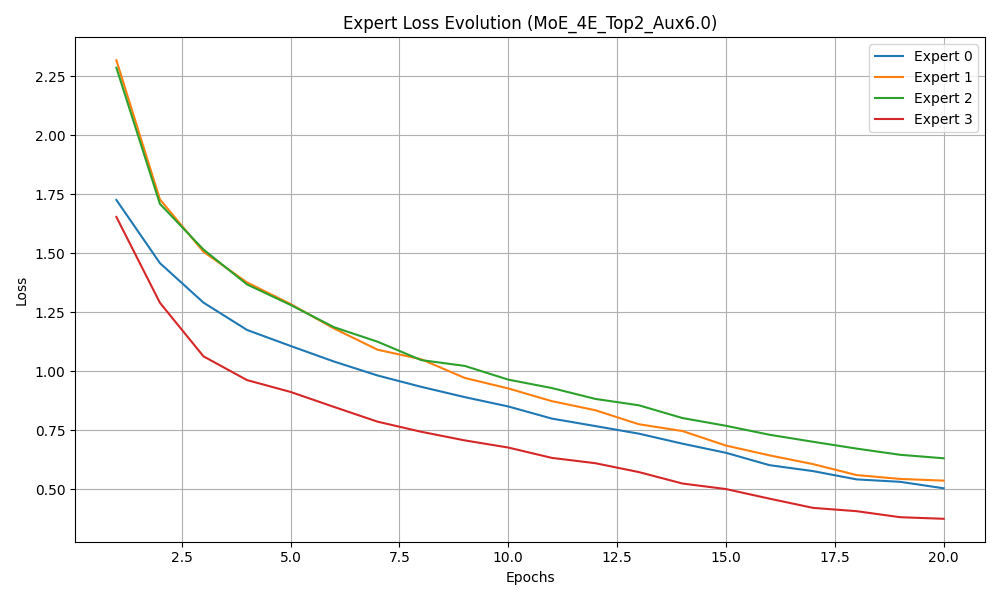


--- Analyzing MoE_8E_Top2_Aux10.0 ---


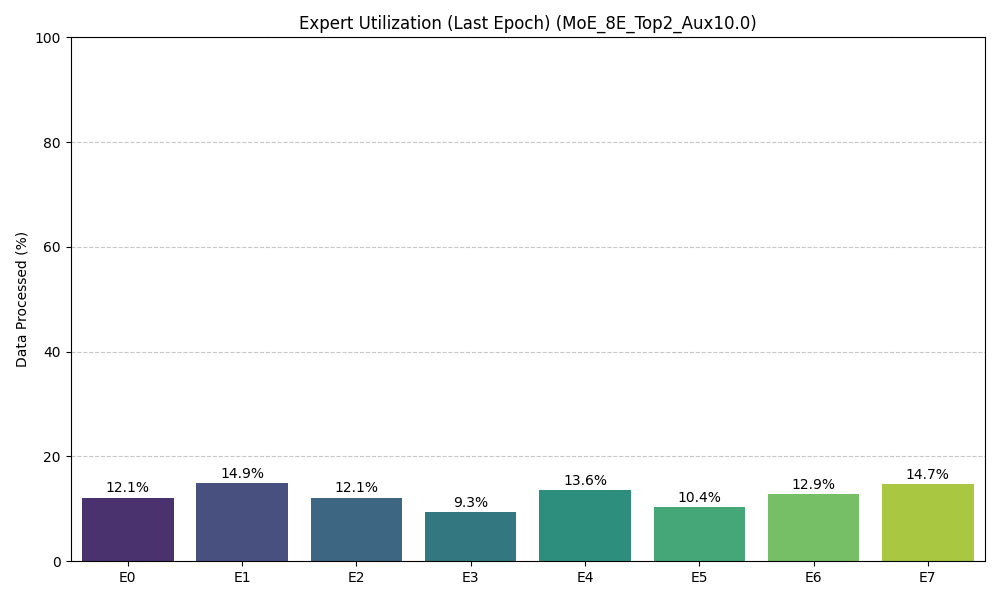

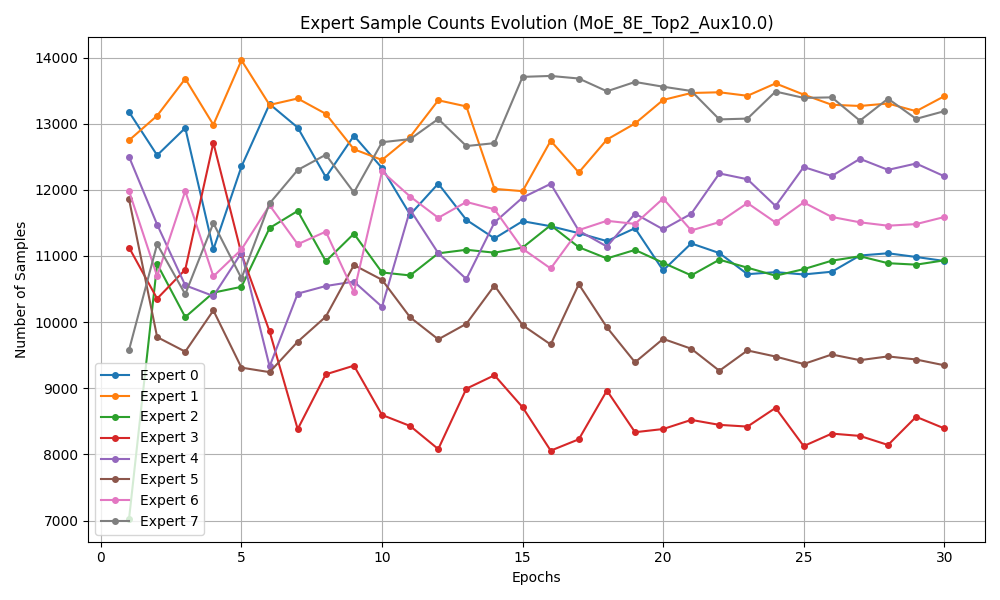

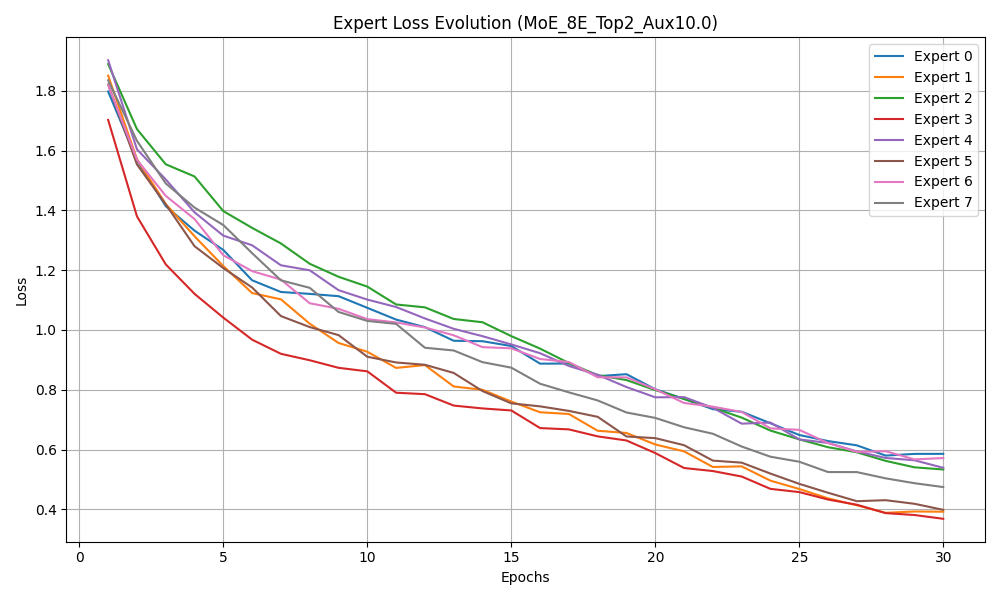

In [6]:
# Analyze each MoE configuration
for name in moe_histories.keys():
    print(f"\n--- Analyzing {name} ---")
    hist = moe_histories[name]
    
    # 1. Expert Usage Histogram (Last Epoch)
    plot_expert_utilization_histogram(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_utilization_histogram{f"({name})".replace(" ", "_").lower()}.png')))
    
    # 1b. Expert Usage Evolution (Stacked Area)
    # plot_expert_utilization(hist, SAVE_DIR) # Generates 'expert_utilization_evolution.png'
    # Rename it to keep unique
    # os.rename(os.path.join(SAVE_DIR, 'expert_utilization_evolution.png'), 
    #           os.path.join(SAVE_DIR, f'expert_utilization_evolution_{name}.png'))
    
    # 2. Expert Counts Evolution (Line Plot)
    plot_expert_counts_evolution(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_counts_evolution{f"({name})".replace(" ", "_").lower()}.png')))

    # 3. Expert Loss Evolution
    plot_expert_loss_history(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_loss_evolution{f"({name})".replace(" ", "_").lower()}.png')))


# 4. Specialization
Do experts specialize in specific classes (e.g., Expert 0 -> Animals, Expert 1 -> Vehicles)?


--- Specialization: MoE_4E_Top1_Aux0.0 ---


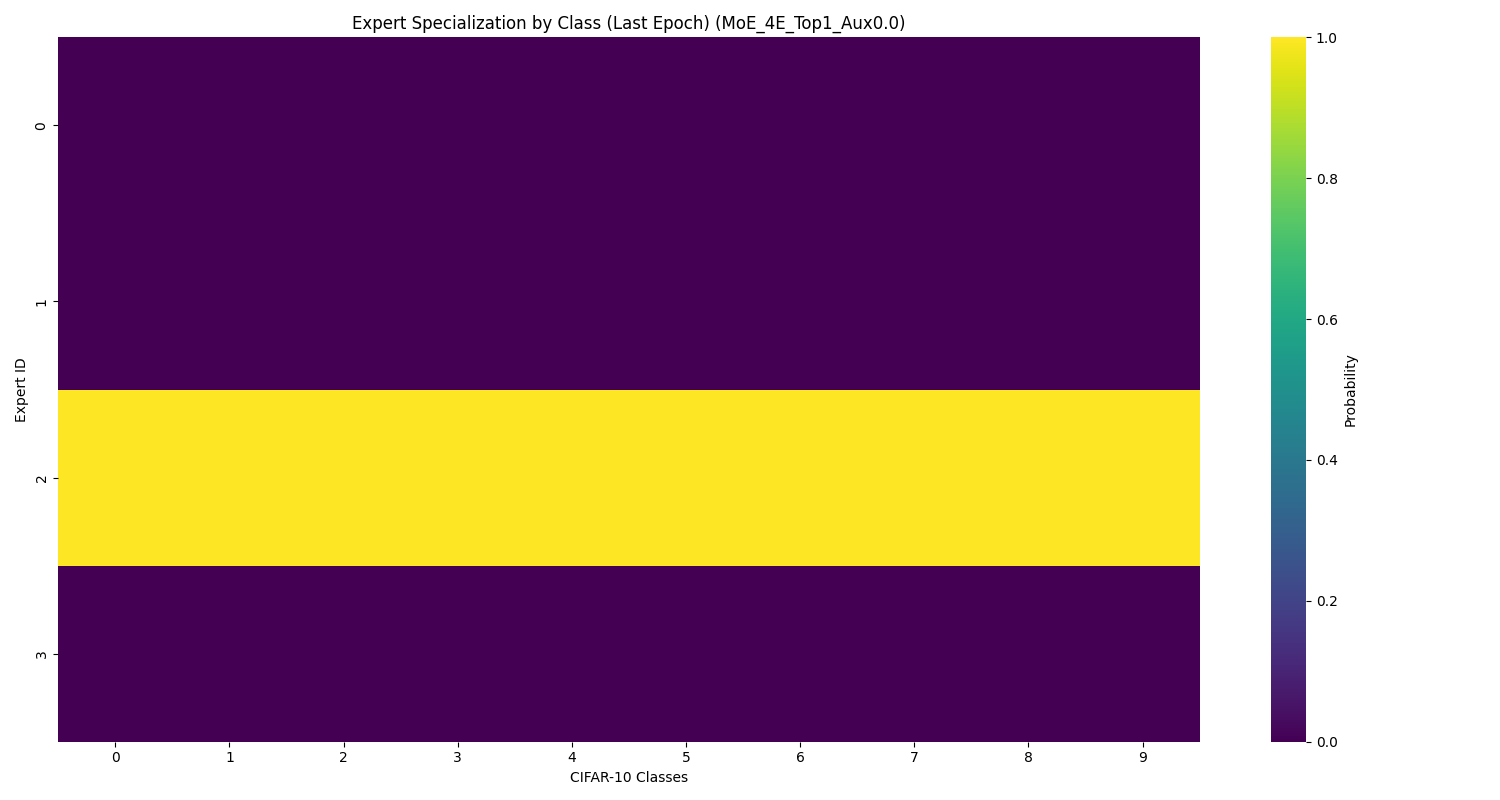


--- Specialization: MoE_4E_Top1_Aux3.0 ---


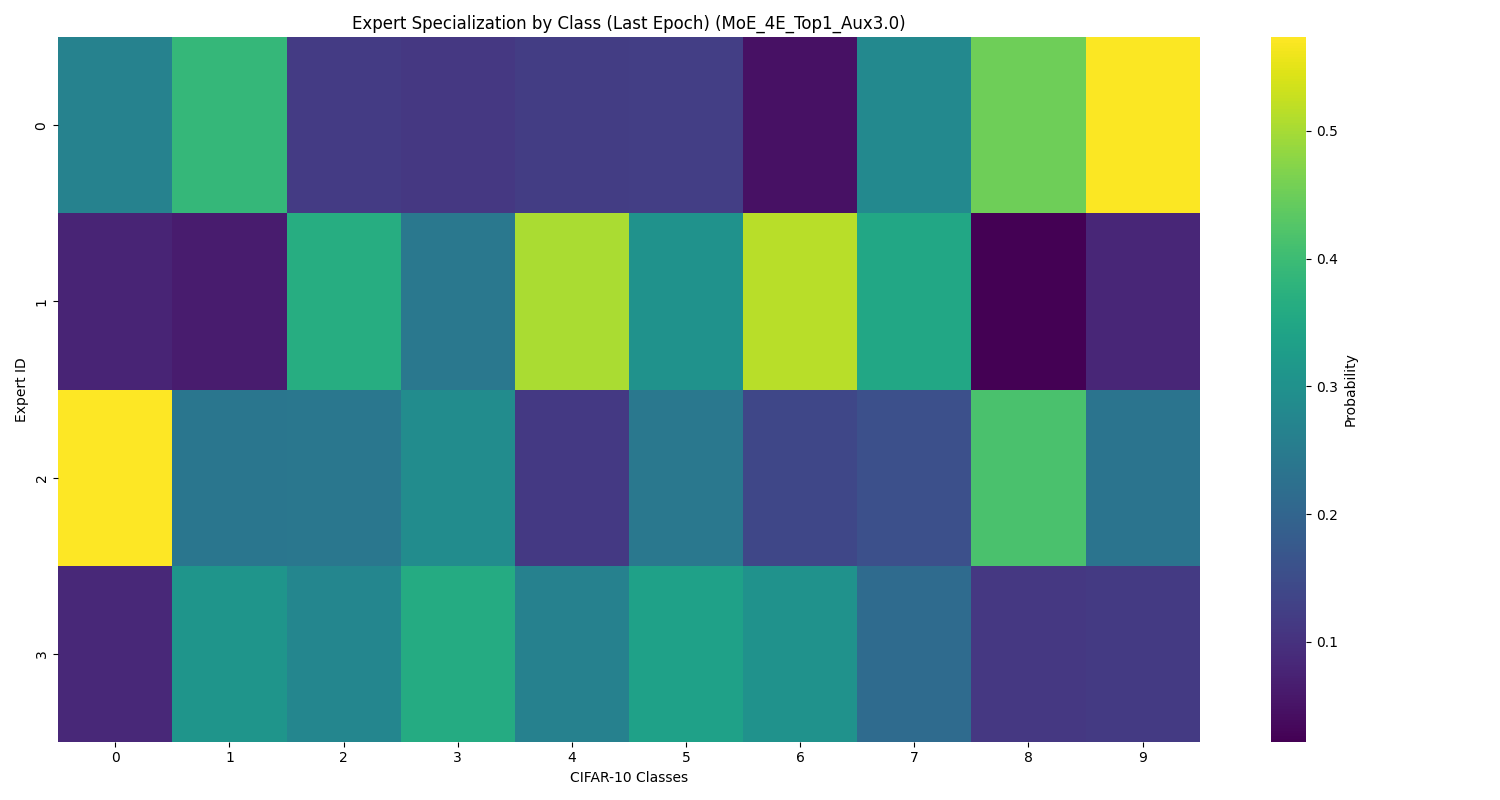


--- Specialization: MoE_4E_Top2_Aux3.0 ---


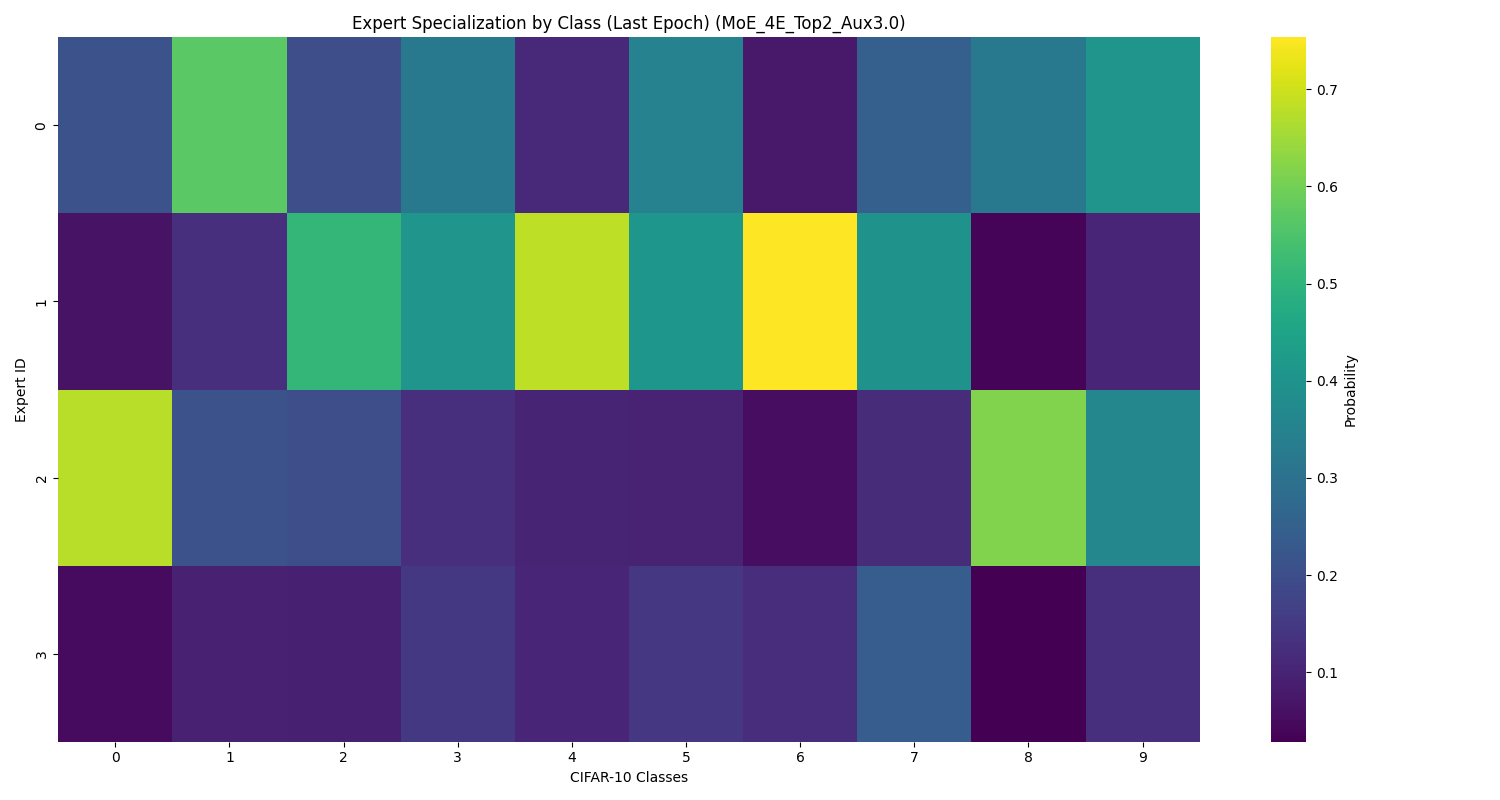


--- Specialization: MoE_4E_Top2_Aux6.0 ---


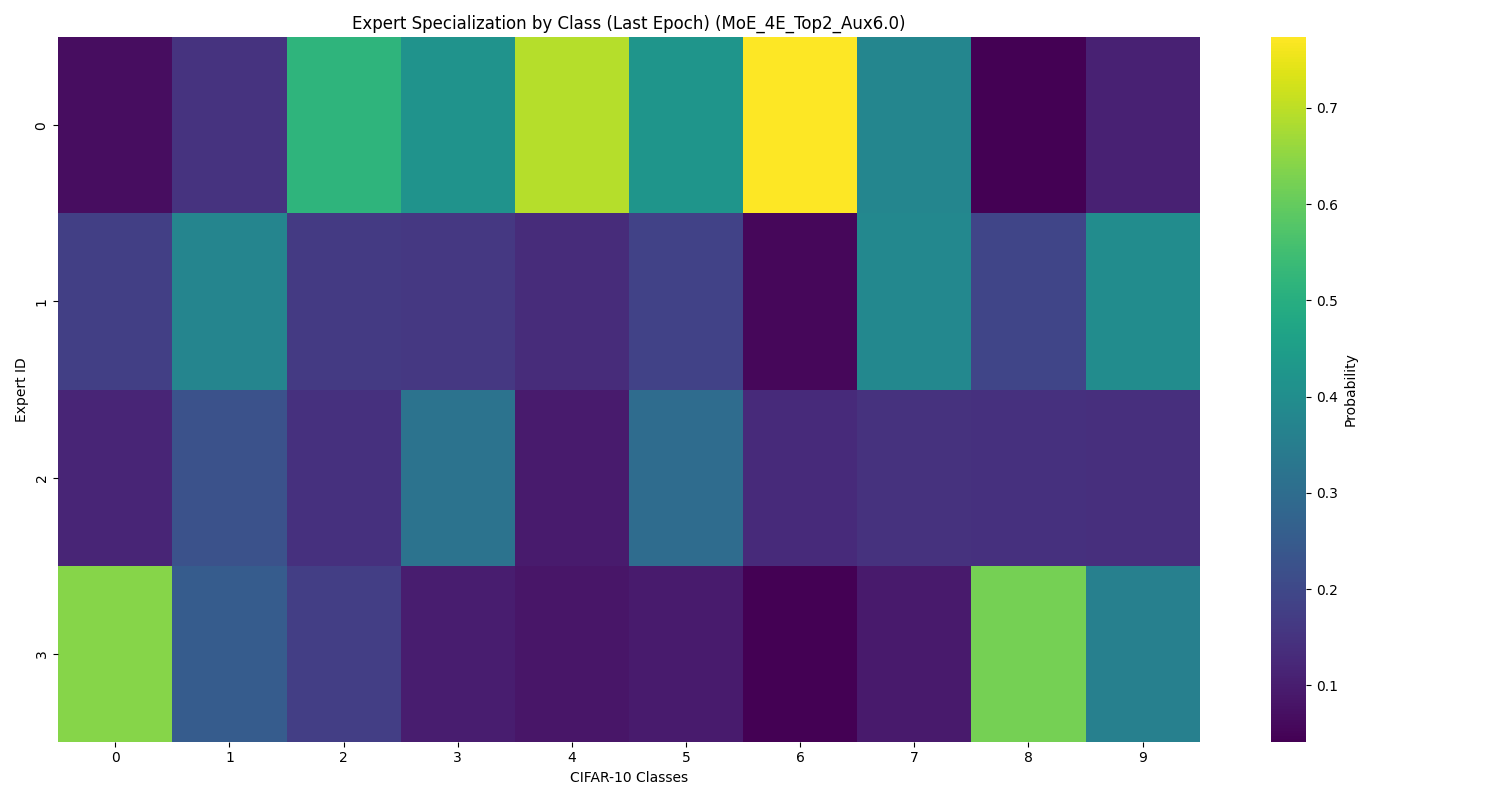


--- Specialization: MoE_8E_Top2_Aux10.0 ---


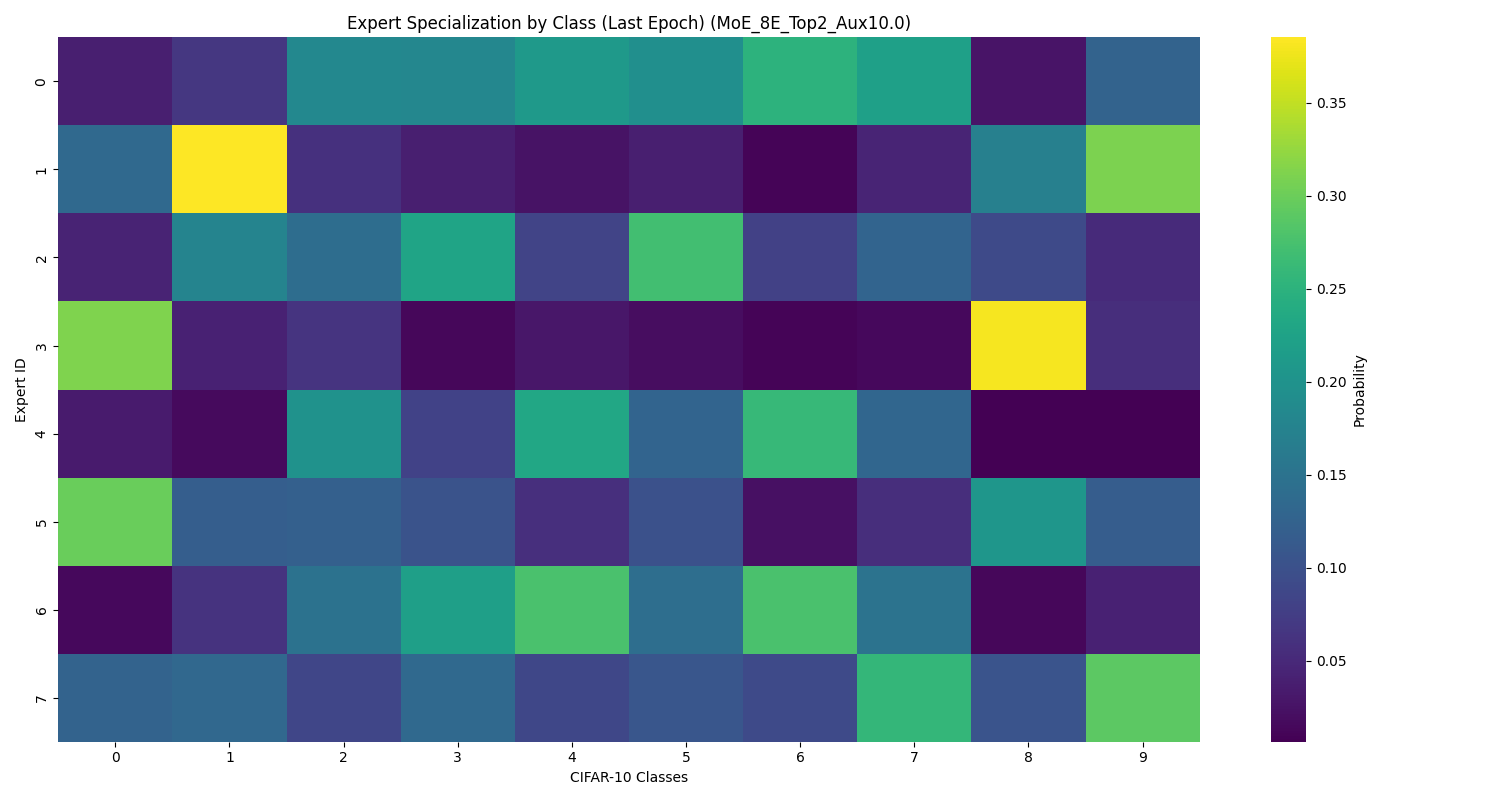

In [7]:
for name in moe_histories.keys():
    print(f"\n--- Specialization: {name} ---")
    hist = moe_histories[name]
    
    plot_expert_heatmap_from_history(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_specialization_heatmap{f"({name})".replace(" ", "_").lower()}.png')))
